<a href="https://colab.research.google.com/github/ArthurMor4is/t-xai/blob/main/mad.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q datasets transformers accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.1/519.1 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 44.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.2/244.2 kB 18.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 20.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 18.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 13.4 MB/s eta 0:00:00


In [2]:
%%capture
!sudo apt -qq install git-lfs
!git config --global credential.helper store

In [22]:
import torch
from PIL import Image
import requests
from transformers import AutoModelForImageClassification, AutoImageProcessor
import requests
import numpy as np
import matplotlib.pyplot as plt

In [20]:
def perform_inference(image: Image, model: torch.nn.Module, processor):
    """Performs inference given an image, a model, and its processor."""
    inputs = processor(image.convert("RGB"), return_tensors="pt")
    with torch.no_grad():
        outputs = model(**inputs, output_attentions=True)
    return outputs

# For vanilla ViT models, this should be 1. For DeiT models,
# this should be two.
num_cls_tokens = 1

def compute_distance_matrix(patch_size, num_patches, length):
    """Helper function to compute distance matrix."""
    distance_matrix = np.zeros((num_patches, num_patches))
    for i in range(num_patches):
        for j in range(num_patches):
            if i == j:  # zero distance
                continue

            xi, yi = (int(i / length)), (i % length)
            xj, yj = (int(j / length)), (j % length)
            distance_matrix[i, j] = patch_size * np.linalg.norm([xi - xj, yi - yj])

    return distance_matrix

def compute_mean_attention_dist(patch_size, attention_weights):
    # The attention_weights shape = (batch, num_heads, num_patches, num_patches)
    attention_weights = attention_weights[
        ..., num_cls_tokens:, num_cls_tokens:
    ]  # Removing the CLS token
    num_patches = attention_weights.shape[-1]
    length = int(np.sqrt(num_patches))
    assert length**2 == num_patches, "Num patches is not perfect square"

    distance_matrix = compute_distance_matrix(patch_size, num_patches, length)
    h, w = distance_matrix.shape

    distance_matrix = distance_matrix.reshape((1, 1, h, w))
    # The attention_weights along the last axis adds to 1
    # this is due to the fact that they are softmax of the raw logits
    # summation of the (attention_weights * distance_matrix)
    # should result in an average distance per token
    mean_distances = attention_weights * distance_matrix
    mean_distances = np.sum(
        mean_distances, axis=-1
    )  # sum along last axis to get average distance per token
    mean_distances = np.mean(
        mean_distances, axis=-1
    )  # now average across all the tokens

    return mean_distances

def gather_mads(attention_scores, patch_size: int = 16):
    all_mean_distances = {
        f"block_{i}_mean_dist": compute_mean_attention_dist(
            patch_size=patch_size, attention_weights=attention_weight.numpy()
        )
        for i, attention_weight in enumerate(attention_scores)
    }
    return all_mean_distances

def visualize_mads(all_mads, ckpt_id):
    num_heads = len(all_mads)
    plt.figure(figsize=(6, 6))

    for idx in range(len(all_mads)):
        mean_distance = all_mads[f"block_{idx}_mean_dist"]
        x = [idx] * num_heads
        y = mean_distance[0, :]
        plt.scatter(x=x, y=y, label=f"attention_head_{idx}")

    plt.xlabel("Block index")
    plt.ylabel("MAD")
    plt.legend(loc="lower right")
    plt.title(ckpt_id, fontsize=14)
    plt.show()

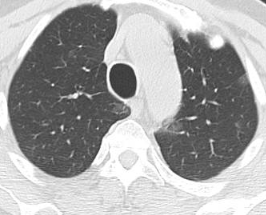

In [27]:
image = Image.open('/content/p.png')
image

In [28]:
repo_name = "ArthurMor4is/vit-base-patch16-224-finetuned-dataset-covid-0"

image_processor = AutoImageProcessor.from_pretrained(repo_name)
model = AutoModelForImageClassification.from_pretrained(repo_name)

In [29]:
patch_size = 16
output = perform_inference(image, model, image_processor)

In [30]:
all_mads = gather_mads(output.attentions, patch_size)

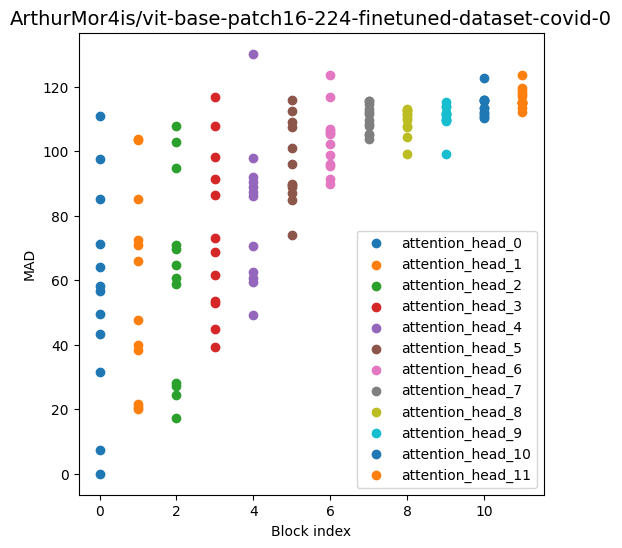

In [31]:
visualize_mads(all_mads, repo_name)